In [1]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import glob 
import os
import warnings
import networkx as nx
import matplotlib.colors as mcolors
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import pearsonr
from sklearn.covariance import GraphicalLassoCV
from networkx.generators.community import gaussian_random_partition_graph
import scipy.stats as stats
from scipy.stats import ttest_ind
import nibabel as nib 
import seaborn as sns

In [2]:
#keep this code with the original for how to create the original csv 
#start with formattting data, getting master csv of all patients regional volume 
#create master csv file with all vol for each region for each patient
#cols would be 'id','001','002'....
#rows would be id numbers 0173

dir = "/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi"
data_dic = {}
patient_data = {}
#iterate through patient folders to extract the values of the .npy files 
for folder in sorted(glob.glob(os.path.join(dir,"wneuromorphometrics_*"))):
    # print(f"processing: {folder}")
    id = folder[-4:]
    volumes = []
    #data dicitonary to store corresponding labels and values 
    for file in sorted(glob.glob(os.path.join(folder, "*.npy"))): #search for all .npy files 
        reg_num = os.path.splitext(os.path.basename(file))[0] #os.path.basename returns filename itself with extension
        #os.path.splittext()[0] splits file basename into a tuple of file name string and the extension (001,.npy) [0] tells it to extract first el of this tuple (001)
        # print(reg_num)
        node_data = np.load(file)
        # print(reg_num, node_data)
        data_dic[reg_num]=node_data
        volumes.append(node_data)

    patient_data[id]=volumes

patient_ids = list(patient_data.keys())

progs_norm = pd.DataFrame.from_dict(patient_data,orient='index')
progs_norm.columns = [str(int(col) + 1) for col in progs_norm.columns]
progs_norm['id'] = patient_ids
progs_norm.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/mega_csv.csv')
print(progs_norm.shape)
print(progs_norm)

(545, 143)
            1    2    3    4    5    6    7    8     9    10  ...    134  \
0173  1461786  118  285  303  150  150  350  352  5258  6796  ...  11021   
0307  1460313  117  285  302  149  154  347  354  5277  6769  ...  11041   
0331  1459847  119  285  303  147  153  349  354  5277  6786  ...  11009   
0376  1461197  120  284  302  149  138  349  354  5261  6758  ...  11035   
0388  1462081  121  285  302  149  151  348  355  5289  6766  ...  11023   
...       ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...    ...   
6627  1461387  117  285  303  149  154  349  355  5272  6797  ...  10983   
6632  1459008  119  285  302  152  155  350  355  5279  6850  ...  11093   
6635  1456677  111  275  300  148  153  349  347  5283  6838  ...  11038   
6652  1458206  119  283  301  151  152  352  354  5274  6808  ...  11087   
6668  1458654  115  282  301  147  153  351  352  5303  6825  ...  11062   

       135   136   137   138   139   140   141   142    id  
0173  5701  635

In [3]:
#add in progression info and then split dataframes into stable and progressive mci 
prog_info = pd.read_csv("/data2/MRI_PET_DATA/graph/csvs/ADNI_surv_prog.csv")
# all_df = pd.read_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/hip_weights.csv") #doesn't work if I just read it in as a csv weird 

prog = prog_info[['RID',"PROGRESSES"]]
#add in padded zeros to prog df 
prog['RID']=prog["RID"].astype(str).str.zfill(4)

#filter prog to only include ids we want 
prog = prog[prog["RID"].isin(progs_norm['id'].astype(str))]
print(f"N Progressive MCI={prog['PROGRESSES'].value_counts()[1]}\nN Stable MCI={(545-154)}")  #in entire dataset, only 154 who progress 

#merge all_df df and prog df on index RID and ID
merged = prog.merge(progs_norm,left_on='RID', right_on='id')

merged = merged.drop('id',axis=1) #drop id along col axis 

N Progressive MCI=154
N Stable MCI=391


/tmp/ipykernel_69398/3520169288.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog['RID']=prog["RID"].astype(str).str.zfill(4)


In [4]:
#separate dfs for progressors and stable 
progs = pd.DataFrame()
stable = pd.DataFrame()

for index,row in merged.iterrows():
    if row['PROGRESSES']==1:
        progs = progs.append(row)
    else:
        stable = stable.append(row)
print(progs)
print(stable)

progs.to_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/progressors_vol.csv")
stable.to_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/stable_vol.csv")

      RID  PROGRESSES        1    2    3    4    5    6    7    8  ...    133  \
2    0331         1.0  1459847  119  285  303  147  153  349  354  ...  11197   
3    0376         1.0  1461197  120  284  302  149  138  349  354  ...  11205   
4    0388         1.0  1462081  121  285  302  149  151  348  355  ...  11225   
7    0423         1.0  1461269  122  284  302  150  152  352  351  ...  11261   
8    0429         1.0  1462322  122  285  303  151  154  348  356  ...  11184   
..    ...         ...      ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
467  4974         1.0  1461260  119  285  303  149  150  349  354  ...  11260   
476  5026         1.0  1459352  119  284  303  151  154  348  353  ...  11251   
484  5285         1.0  1461867  120  286  301  150  150  344  357  ...  11225   
502  6252         1.0  1459859  119  281  303  150  154  350  352  ...  11277   
514  6345         1.0  1461470  122  283  302  149  153  349  356  ...  11281   

       134   135   136   13

In [5]:
#drop rows for ventricles, chaism, csf, and background (not regions so we don't want)
#drop 1,2,3,4,23,24,25,26,35,36
progs_d = progs.drop(['1','2','3','4','19','20','23','24','25','26','35','36'], axis =1)
stable_d = stable.drop(['1','2','3','4','19','20','23','24','25','26','35','36'], axis =1)

progs_d.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/ADNI_pruned_prog_csv.csv')
stable_d.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/ADNI_pruned_stable_csv.csv')

In [6]:
#for the correlation matrix need to only have the values so drop the id and labels 
progs_dd = progs_d.drop(["RID","PROGRESSES"], axis =1)
print(progs_dd)
stable_dd = stable_d.drop(["RID","PROGRESSES"], axis =1)

       5    6    7    8     9    10    11    12     13     14  ...    133  \
2    147  153  349  354  5277  6786  1175  1282  32293  32690  ...  11197   
3    149  138  349  354  5261  6758  1171  1283  32213  32643  ...  11205   
4    149  151  348  355  5289  6766  1171  1285  32082  32421  ...  11225   
7    150  152  352  351  5263  6809  1174  1282  32196  32550  ...  11261   
8    151  154  348  356  5251  6789  1173  1283  32000  32318  ...  11184   
..   ...  ...  ...  ...   ...   ...   ...   ...    ...    ...  ...    ...   
467  149  150  349  354  5260  6753  1170  1284  32089  32476  ...  11260   
476  151  154  348  353  5286  6779  1168  1280  32228  32548  ...  11251   
484  150  150  344  357  5266  6771  1173  1284  32146  32482  ...  11225   
502  150  154  350  352  5282  6812  1175  1279  32424  32764  ...  11277   
514  149  153  349  356  5272  6767  1173  1283  32108  32468  ...  11281   

       134   135   136   137   138   139   140   141   142  
2    11009  58

In [ ]:
#check for nan values in dataframe 

In [7]:
#convert to float
progs_f = progs_dd.astype(float)
stable_f = stable_dd.astype(float)
# print(stable)

In [ ]:
#have to do standard scalar normalization 
#it normalizes by column 
#sklearn standard scalar 

In [8]:
#normalize with z score, negative values are fine it means its an std below mean 
progs_norm = (progs_f - progs_f.mean()) / progs_f.std()
stable_norm = (stable_f - stable_f.mean()) / stable_f.std()
# print(progs_norm)

In [10]:
#NEEDS TO BE 154x130 format for model
progs_norm = progs_norm.T #transpose rows and columns
print(progs_norm.shape)

(154, 130)


In [ ]:
#graphical lasso cv not converging 
#can adjust the tolerance, regularization parameter alphas, change solver method, increase max iterations, or random seed 
#example 
#model = GraphicalLassoCV(tol=1e-3)  # Increase tolerance level
#alphas = [0.1, 1.0, 10.0]  # Example list of alpha values to search
#model = GraphicalLassoCV(alphas=alphas)

#model = GraphicalLassoCV(solver='graph_lasso')  # Try a different solver
#model = GraphicalLassoCV(max_iter=500)  # Increase maximum iterations
#model = GraphicalLassoCV(random_state=42)  # Set a random seed




In [11]:
#graphical lasso 
#converges with 500 iterations 
#estimates the precision matrix of the data (inverse cov mat which models the partial correlations between vars)
#uses lasso penalty, during training the model iteratively updates the estimated precision matrix using current hyperparamter values until it converges to a set of values that minimize the loss function 
model = GraphicalLassoCV(cv=5,max_iter=500) 

#true the defaults that he suggested 
#set alpha [1,10] so that its not continually searching for one 
#n_jobs = -1 try all avalible cores 


#cv=5 specifies 5-fold cross validation strategy to optimize model hyperparameters 
model.fit(progs_norm)
#have 1 rv per node (volumes), find out the optimization details, theorteically estimating corr mat of vars 


#have data, then unconnected random var,s est cov mat, and this estimation has penalty to force very small numbers to be 0 (force some sparsity) then interpret the inverse cov matrix as an adjacency matrix, and then visualize as a graph 
#makes sense to trat as random var, they are connecte din some sense if they are correlated 

#drop the very small nunvbwers, l1 sets very small things to 0, choses hyper parater by cross validation 

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(cv=5, max_iter=500)

In [46]:
#RuntimeWarning: invalid value encountered in subtract x = asanyarray(arr - arrmean) 
#check data for nan values 
nan_mask = progs_norm.isna()
nan_count = nan_mask.sum().sum()
print(nan_count)

#under the assumption the vars are gaussian and correlated oit is estimated cov matrix 
#plot histrogram (for one brain region)
#if you have random var that is sum of other random var, with finite variance, then CLT holds, if its the sum of many processed, then it's reasonably gaussian 

#for embeddings - sklearkn might have covariance betwen 2 random vars, use dot product of vectors instead of product 

0


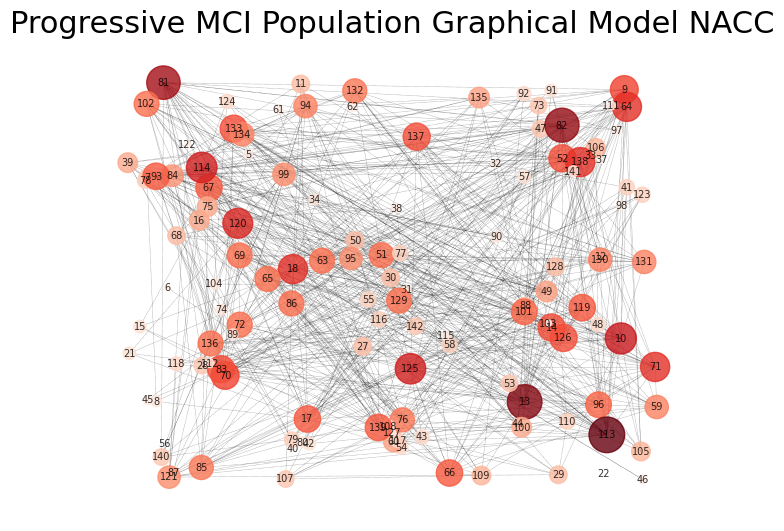

In [12]:
#node size based on connectivity 
#assigns node labels based on the column id 
precision_matrix_p = model.precision_
np.fill_diagonal(precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 

G_prog = nx.Graph(precision_matrix_p)
#create a dictionary that maps old node labels to new node labels
node_labels = {i: label for i, label in enumerate(progs_norm.columns)}

#relabel the nodes in the graph using the dictionary
G_prog = nx.relabel_nodes(G_prog, node_labels)

# Assuming you already have precision_matrix_np and G_n_prog as in your code
# Calculate the node degrees (connectivity strength)
node_degrees = dict(G_prog.degree())

# Scale the node sizes based on node degrees
node_sizes = [20 * node_degrees[node] for node in G_prog.nodes()]

# Create a colormap for node colors based on node degrees
node_colors = list(node_degrees.values())

# Draw the graph with node sizes and colors
pos = nx.random_layout(G_prog)
nx.draw(
    G_prog,
    pos,
    with_labels=True,
    font_size=7,
    style="dotted",
    node_color=node_colors,
    cmap=plt.cm.Reds,
    node_size=node_sizes,
    alpha=0.8,
    width=0.3,
)

plt.title("Progressive MCI Population Graphical Model ADNI", fontsize=22)
plt.show()

#the random layout changes, to have the same one run the layout finctiopn first, choose what I want and then try it later 
#circular one might be good or spectral (bc it uses info on the degree of each node aware of hubs)
#since these are random seed rnadom generator to generate same layout 
#generate positions once and then pass same poisition dictioary 
#network x is generating citionary of 2d positins to draw function 
#draw in circle (then spot patterns that way)

/tmp/ipykernel_308064/609676330.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Node Degree (Centrality)")


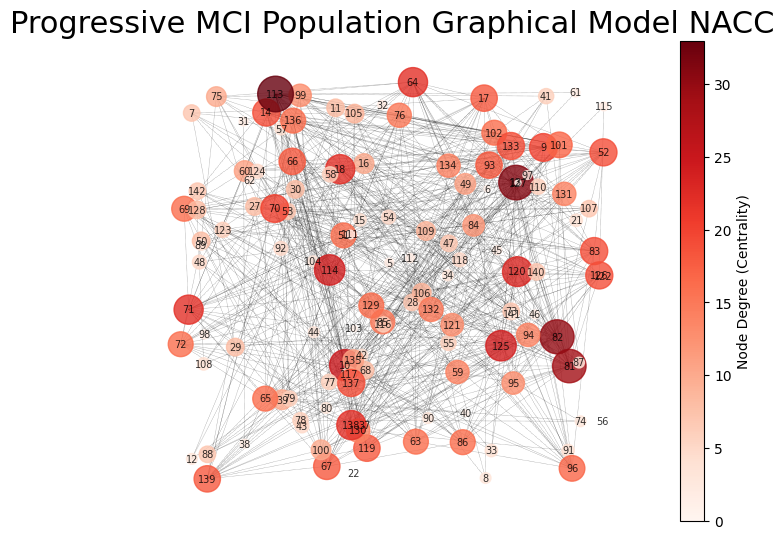

In [49]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have precision_matrix_p, G_prog, and node_labels as in your code
# Calculate the node degrees (connectivity strength)
node_degrees = dict(G_prog.degree())

# Scale the node sizes based on node degrees
node_sizes = [20 * node_degrees[node] for node in G_prog.nodes()]

# Create a colormap for node colors based on node degrees (centrality)
node_colors = [node_degrees[node] for node in G_prog.nodes()]
cmap = plt.cm.Reds  # Choose a colormap (you can change this)

# Normalize node colors to fit within the colormap's range
min_node_color = min(node_colors)
max_node_color = max(node_colors)
node_colors_normalized = [(x - min_node_color) / (max_node_color - min_node_color) for x in node_colors]

# Draw the graph with node sizes and colors
pos = nx.random_layout(G_prog)
nx.draw(
    G_prog,
    pos,
    with_labels=True,
    font_size=7,
    style="dotted",
    node_color=node_colors_normalized,  # Use the normalized node colors
    cmap=cmap,
    node_size=node_sizes,
    alpha=0.8,
    width=0.3,
)

# Add a colorbar to the plot to show the color gradient
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_node_color, vmax=max_node_color))
sm.set_array([])  # An empty array for the colorbar
plt.colorbar(sm, label="Node Degree (Centrality)")

plt.title("Progressive MCI Population Graphical Model ADNI ", fontsize=22)
plt.show()



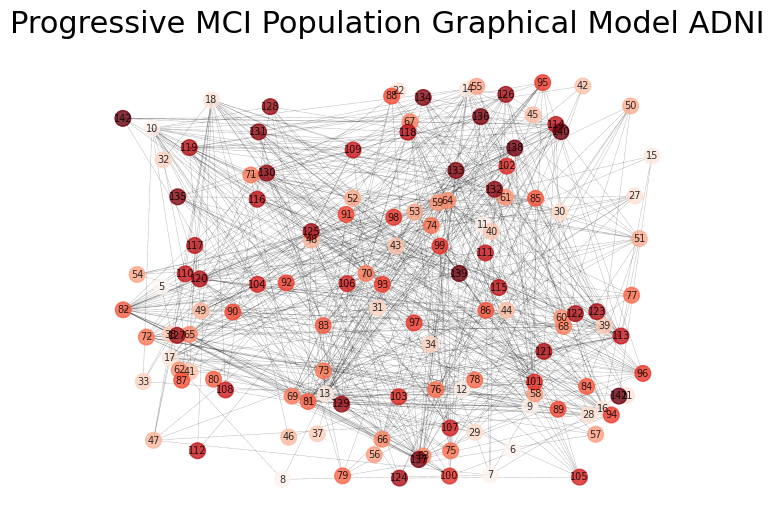

In [21]:
#edges represents conditional independence structure of data, strength and direction of a relationship between 
#this graph has learned and pruned the weaker connections in the precision matrix
#graph represents the strongest and most important connections between the brain volume 

#assigns node labels based on the column id 
precision_matrix_p = model.precision_
np.fill_diagonal(precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 

G_prog = nx.Graph(precision_matrix_p)
#create a dictionary that maps old node labels to new node labels
node_labels = {i: label for i, label in enumerate(progs_norm.columns)}

#relabel the nodes in the graph using the dictionary
G_prog = nx.relabel_nodes(G_prog, node_labels)




#visualize the relabeled graph
pos = nx.random_layout(G_prog)
nx.draw(G_prog, pos, with_labels=True, font_size=7, style="dotted",
        node_color=range(len(G_prog)), cmap=plt.cm.Reds,
        node_size=150*len(G_prog)/154, alpha=.8, width=.3)
plt.title("Progressive MCI Population Graphical Model ADNI", fontsize=22)
plt.show()

In [13]:
#calc degree centrality of each node and organize it as a descending list 
# Assuming you already have G_prog as your graph
# Calculate degree centrality
deg_centrality = nx.degree_centrality(G_prog)

# Sort nodes by degree centrality in descending order
sorted_nodes = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the sorted list of nodes and their degree centrality
for node, centrality in sorted_nodes:
    print(f"Node {node}: Degree Centrality = {centrality:.4f}")


Node 113: Degree Centrality = 0.2558
Node 13: Degree Centrality = 0.2403
Node 82: Degree Centrality = 0.2326
Node 81: Degree Centrality = 0.2248
Node 10: Degree Centrality = 0.1938
Node 114: Degree Centrality = 0.1860
Node 125: Degree Centrality = 0.1860
Node 120: Degree Centrality = 0.1783
Node 18: Degree Centrality = 0.1705
Node 64: Degree Centrality = 0.1705
Node 71: Degree Centrality = 0.1705
Node 138: Degree Centrality = 0.1705
Node 9: Degree Centrality = 0.1550
Node 70: Degree Centrality = 0.1550
Node 14: Degree Centrality = 0.1473
Node 52: Degree Centrality = 0.1473
Node 83: Degree Centrality = 0.1473
Node 126: Degree Centrality = 0.1473
Node 133: Degree Centrality = 0.1473
Node 137: Degree Centrality = 0.1473
Node 17: Degree Centrality = 0.1395
Node 66: Degree Centrality = 0.1395
Node 67: Degree Centrality = 0.1395
Node 93: Degree Centrality = 0.1395
Node 119: Degree Centrality = 0.1395
Node 139: Degree Centrality = 0.1395
Node 96: Degree Centrality = 0.1318
Node 101: Degree Ce

In [14]:
#strongest edges sorted 
#the numbers are region ids which you can find in the neuromorphometrics.csv
edges_sorted = sorted(G_prog.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(int(edge[0]), int(edge[1]), edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(18, 78, {'weight': 0.26528704470524933})
(39, 66, {'weight': 0.21076415469053253})
(17, 29, {'weight': 0.20689720972061068})
(18, 30, {'weight': 0.19506997509235965})
(18, 28, {'weight': 0.18189767904475218})
(18, 48, {'weight': 0.16901224400164788})
(12, 18, {'weight': 0.15891265129678692})
(17, 77, {'weight': 0.1319382532853895})
(17, 27, {'weight': 0.12871165402894702})
(18, 110, {'weight': 0.12369262957813873})


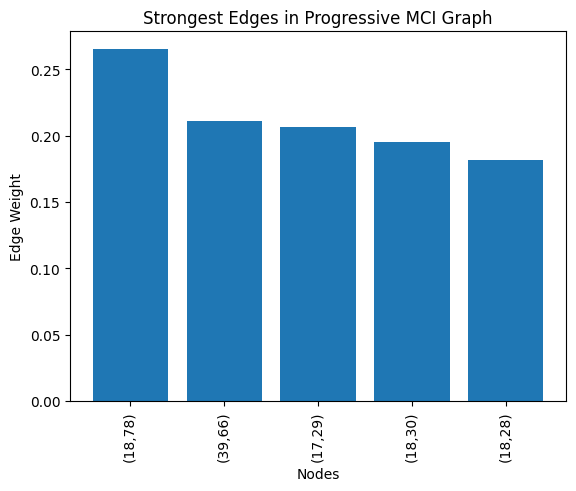

In [15]:
#plot 
top_edges = edges_sorted_shifted[:5]
x_values = [f"({edge[0]},{edge[1]})" for edge in edges_sorted_shifted[:5]]
y_values = [edge[2]['weight'] for edge in edges_sorted_shifted[:5]]

plt.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.xlabel('Nodes')
plt.ylabel('Edge Weight')
plt.title('Strongest Edges in Progressive MCI Graph')
plt.show()

In [17]:
#transpose stable 
stable_norm = stable_norm.T
print(stable_norm.shape)  #shape needs to be 390 x 140 patients x regions 

(390, 130)


In [18]:
#fit for stable df 
#this one did converge 
stab_model = GraphicalLassoCV(cv=5, max_iter=500)
stab_model.fit(stable_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(cv=5, max_iter=500)

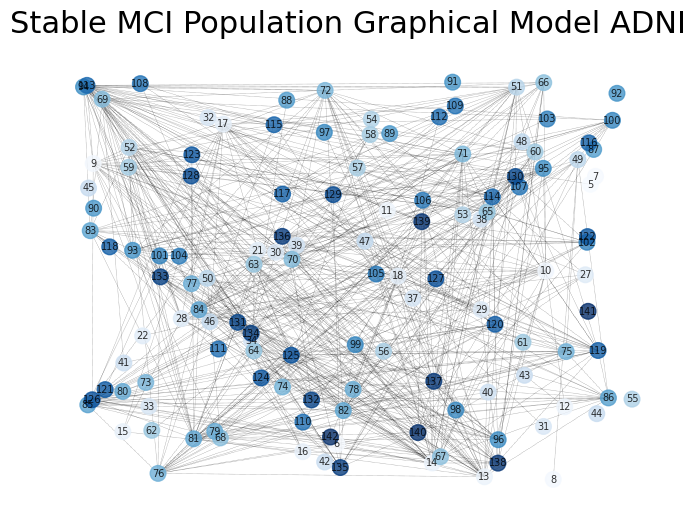

In [19]:
precision_matrix_s = stab_model.precision_
np.fill_diagonal(precision_matrix_s, 0) #removes self connections by replacing the diagnonal of matrix with 0 

G_stab = nx.Graph(precision_matrix_s)
#create a dictionary that maps old node labels to new node labels
node_labels = {i: label for i, label in enumerate(stable_norm.columns)}

#relabel the nodes in the graph using the dictionary
G_stab = nx.relabel_nodes(G_stab, node_labels)

#visualize the relabeled graph
pos = nx.random_layout(G_stab)
nx.draw(G_stab, pos, with_labels=True, font_size=7, style="dotted",
        node_color=range(len(G_stab)), cmap=plt.cm.Blues,
        node_size=150*len(G_stab)/154, alpha=.8, width=.3)
plt.title("Stable MCI Population Graphical Model ADNI", fontsize=22)
plt.show()

In [21]:
#calc degree centrality of each node and organize it as a descending list for stable 
# Assuming you already have G_prog as your graph
# Calculate degree centrality
deg_centrality_stab = nx.degree_centrality(G_stab)

# Sort nodes by degree centrality in descending order
sorted_nodes_stab = sorted(deg_centrality_stab.items(), key=lambda x: x[1], reverse=True)

# Print the sorted list of nodes and their degree centrality
for node, centrality in sorted_nodes_stab:
    print(f"Node {node}: Degree Centrality = {centrality:.4f}")

Node 81: Degree Centrality = 0.2558
Node 13: Degree Centrality = 0.2403
Node 14: Degree Centrality = 0.2326
Node 82: Degree Centrality = 0.2326
Node 114: Degree Centrality = 0.2016
Node 72: Degree Centrality = 0.1938
Node 51: Degree Centrality = 0.1860
Node 113: Degree Centrality = 0.1860
Node 52: Degree Centrality = 0.1783
Node 125: Degree Centrality = 0.1783
Node 18: Degree Centrality = 0.1705
Node 76: Degree Centrality = 0.1705
Node 119: Degree Centrality = 0.1705
Node 9: Degree Centrality = 0.1628
Node 10: Degree Centrality = 0.1628
Node 70: Degree Centrality = 0.1628
Node 93: Degree Centrality = 0.1628
Node 126: Degree Centrality = 0.1628
Node 137: Degree Centrality = 0.1628
Node 71: Degree Centrality = 0.1550
Node 134: Degree Centrality = 0.1550
Node 17: Degree Centrality = 0.1473
Node 69: Degree Centrality = 0.1473
Node 94: Degree Centrality = 0.1473
Node 28: Degree Centrality = 0.1395
Node 84: Degree Centrality = 0.1395
Node 133: Degree Centrality = 0.1395
Node 136: Degree Cent

In [22]:
#strongest 10 edges 
edges_sorted = sorted(G_stab.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(int(edge[0]), int(edge[1]), edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(18, 78, {'weight': 0.27783956633253576})
(17, 77, {'weight': 0.2586528197553451})
(17, 29, {'weight': 0.21298144204037386})
(17, 103, {'weight': 0.16973816862326385})
(17, 27, {'weight': 0.15968144723422525})
(18, 30, {'weight': 0.1437351771043876})
(17, 28, {'weight': 0.13042776487967941})
(17, 47, {'weight': 0.12334081201739118})
(18, 48, {'weight': 0.1228802172175597})
(18, 46, {'weight': 0.1227428875966686})


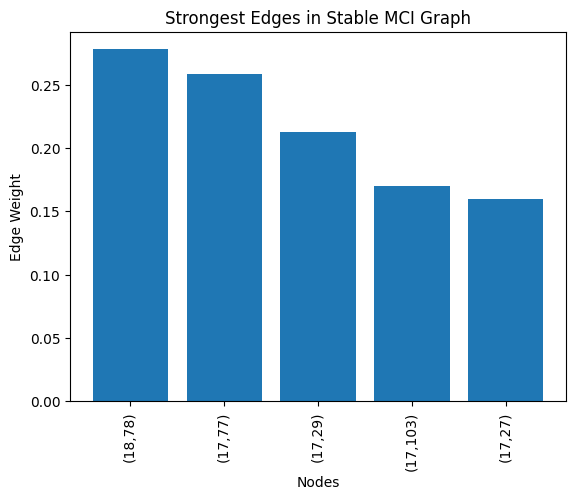

In [23]:
#plot 
top_edges = edges_sorted_shifted[:5]

x_values = [f"({edge[0]},{edge[1]})" for edge in edges_sorted_shifted[:5]]
y_values = [edge[2]['weight'] for edge in edges_sorted_shifted[:5]]

plt.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.xlabel('Nodes')
plt.ylabel('Edge Weight')
plt.title('Strongest Edges in Stable MCI Graph')
plt.show()

In [24]:
##compare graph metrics for andi 

#modularity 
mod_p = nx.algorithms.community.modularity(G_prog, nx.algorithms.community.greedy_modularity_communities(G_prog))
print("Prog Modularity:", mod_p)
mod_s = nx.algorithms.community.modularity(G_stab, nx.algorithms.community.greedy_modularity_communities(G_stab))
print("Stable Modularity:", mod_s)

#global path effiency 
ge_p = nx.global_efficiency(G_prog)
print("\nProg Global efficiency:", ge_p)
ge_s = nx.global_efficiency(G_stab)
print("Stable Global efficiency:", ge_s)

#clustering coefficient 
cl_p = nx.average_clustering(G_prog)
print(f"\nProg Clustering Coeff:",cl_p)
cl_s = nx.average_clustering(G_stab)
print(f"Stable Clustering Coeff",cl_s)

Prog Modularity: 0.16637832705910233
Stable Modularity: 0.2699519061214878

Prog Global efficiency: 0.4212343470482634
Stable Global efficiency: 0.2996998608626528

Prog Clustering Coeff: 0.24890969775265448
Stable Clustering Coeff 0.28867990738129456


In [32]:
#additional metrics for ADNI 
#degree centrality, but its for each node so it's a lot of data 
deg_p = nx.degree_centrality(G_prog)
print(f"degree centrality: {deg_p}")

degree centrality: {'5': 0.015503875968992248, '6': 0.007751937984496124, '7': 0.05426356589147287, '8': 0.023255813953488372, '9': 0.15503875968992248, '10': 0.1937984496124031, '11': 0.06201550387596899, '12': 0.023255813953488372, '13': 0.24031007751937983, '14': 0.14728682170542634, '15': 0.031007751937984496, '16': 0.07751937984496124, '17': 0.13953488372093023, '18': 0.17054263565891473, '21': 0.031007751937984496, '22': 0.0, '27': 0.06201550387596899, '28': 0.05426356589147287, '29': 0.06201550387596899, '30': 0.06201550387596899, '31': 0.015503875968992248, '32': 0.015503875968992248, '33': 0.031007751937984496, '34': 0.023255813953488372, '37': 0.007751937984496124, '38': 0.015503875968992248, '39': 0.07751937984496124, '40': 0.007751937984496124, '41': 0.046511627906976744, '42': 0.031007751937984496, '43': 0.03875968992248062, '44': 0.023255813953488372, '45': 0.015503875968992248, '46': 0.015503875968992248, '47': 0.05426356589147287, '48': 0.03875968992248062, '49': 0.0852

In [30]:
#start with formattting data, getting master csv of all patients regional volume 
#create master csv file with all vol for each region for eahc patient
#cols would be 'id','001','002'....
#rows would be id numbers 0173

#fiugre out why this isnt working correctly 
#change this for NACC dataset

dir_n = "/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi"
data_dic_n = {}
patient_data_n = {}
#iterate through patient folders to extract the values of the .npy files 
#need touble check this by printing id because NACC folders have naming convention NACC[0-9][0-9][0-9][0-9][0-9][0-9]
for folder in sorted(glob.glob(os.path.join(dir_n,"NACC*"))):
    # print(f"processing: {folder}")
    id = folder[-6:]

    # print(id)
    volumes = []
    #data dicitonary to store corresponding labels and values 
    for file in sorted(glob.glob(os.path.join(folder, "*.npy"))): #search for all .npy files 
        reg_num = os.path.splitext(os.path.basename(file))[0] #os.path.basename returns filename itself with extension
        #os.path.splittext()[0] splits file basename into a tuple of file name string and the extension (001,.npy) [0] tells it to extract first el of this tuple (001)
        # print(reg_num)
        node_data = np.load(file)
        # print(reg_num, node_data)
        data_dic_n[reg_num]=node_data
        volumes.append(node_data)

    patient_data_n[id]=volumes

patient_ids = list(patient_data_n.keys())

df_n = pd.DataFrame.from_dict(patient_data_n,orient='index')
df_n.columns = [str(int(col) + 1) for col in df_n.columns]
df_n['RID'] = patient_ids
#only pad ids that are not already 6 digits 
df_n['RID']=df_n['RID'].apply(lambda x: f"NACC{x:0>6}")
#make rid col the index (first col)
df_n = df_n.set_index('RID').reset_index()


#adding a weird last row to the df with empty values so drop is 
df_n = df_n.drop(df_n.index[-1],axis=0)
#save
df_n.to_csv('/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/mega_NACC.csv')

In [31]:
#add in progression info and then split dataframes into stable and progressive mci 
#find nacc prog info 

prog_info_n = pd.read_csv("/data2/MRI_PET_DATA/graph/csvs/NACC_surv_prog.csv")

prog_n = prog_info_n[['RID',"PROGRESSES"]]
#add in padded zeros to prog df 
prog_n['RID']=prog_n["RID"].astype(str).str.zfill(4)

prog_n = prog_n[prog_n["RID"].isin(df_n['RID'].astype(str))]

prog_n=prog_n.reset_index(drop=True)
# print(f"N Progressive MCI={prog['PROGRESSES'].value_counts()[1]}\nN Stable MCI={(545-154)}")  #in entire dataset, only 154 who progress 
print(f"N Progressive MCI={prog_n['PROGRESSES'].value_counts()[1]}\nN Stable MCI = {(508-130)}")

#merge all_df df and prog df on index RID and ID
merged = pd.merge(prog_n,df_n,on='RID')


N Progressive MCI=130
N Stable MCI = 378


/tmp/ipykernel_69398/3290737766.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog_n['RID']=prog_n["RID"].astype(str).str.zfill(4)


In [32]:
#separate dfs for progressors and stable 
#creat empty dfs 
n_progs = pd.DataFrame()
n_stable = pd.DataFrame()

for index,row in merged.iterrows():
    if row['PROGRESSES']==1:
        n_progs = n_progs.append(row)
    else:
        n_stable = n_stable.append(row)

# print(progs)
# print(stable)

n_progs.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_progressors_vol.csv")
n_stable.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_stable_vol.csv")

In [33]:
#drop row 23 and 25 because they are ventricle and chiasm and have no volume 
# zero_col = df.columns[(df ==0).any()]
# print(zero_col)

#drop 1,2,3,4,23,24,25,26,35,36

n_progs = n_progs.drop(['1','2','3','4','23','24','25','26','35','36'], axis =1)
n_stable = n_stable.drop(['1','2','3','4','23','24','25','26','35','36'], axis =1)

#drop all the ventricles and region 001 because its the background and not the data we need 
#in this the bacground region 0 and region 1 are both combined in region 1 
n_progs.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_progressors_pruned_vol.csv")
n_stable.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_stable_pruned_vol.csv")

In [34]:
#for the correlation matrix need to only have the values 
n_progs = n_progs.drop(["RID","PROGRESSES"], axis =1)
n_stable = n_stable.drop(["RID","PROGRESSES"], axis =1)
#convert to float
n_progs = n_progs.astype(float)
n_stable = n_stable.astype(float)
# print(stable)

In [35]:
#normalize with z score, negative values are fine it means its an std below mean 
n_progs_norm = (n_progs - n_progs.mean()) / n_progs.std()
n_stable_norm = (n_stable - n_stable.mean()) / n_stable.std()
# print(progs_norm)

In [36]:
#NEEDS TO BE 130x 132 format for model  (132 brain regions left)
n_progs_norm = n_progs_norm.T
print(n_progs_norm.shape)

(132, 130)


In [37]:
#this one converged but still invalue value encountered in subtract error 
model = GraphicalLassoCV(cv=5, max_iter=500) #cv=5 specifies 5-fold cross validation strategy to optimize model hyperparameters 
model.fit(n_progs_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 500 iteration: dual gap: -9.309e-04
  warnings.warn(


GraphicalLassoCV(cv=5, max_iter=500)

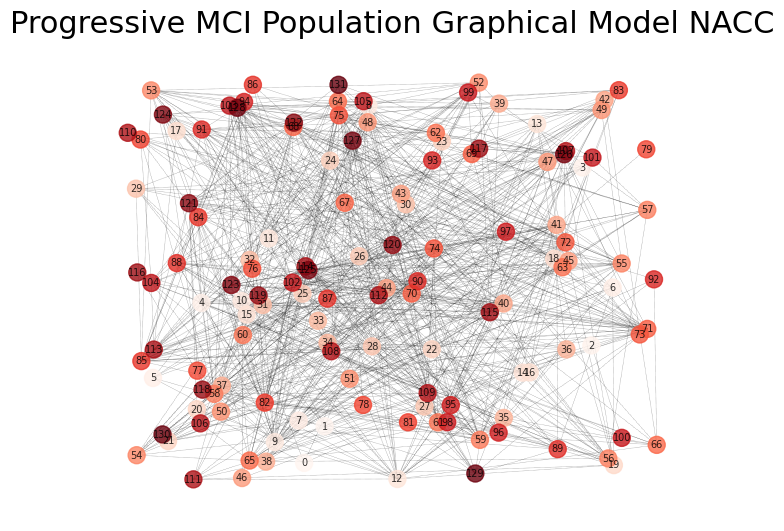

In [66]:
#construct gaussian graphican model for NACC progressive MCI 
precision_matrix_np = model.precision_
np.fill_diagonal(precision_matrix_np, 0)
G_n_prog = nx.Graph(precision_matrix_np)
pos = nx.random_layout(G_n_prog)
nx.draw(G_n_prog, pos,with_labels=True, font_size=7, style="dotted", node_color=range(len(precision_matrix_np)),
        cmap=plt.cm.Reds, node_size=150*len(precision_matrix_np)/132, alpha=.8, width=.3)
#size inconsistent and makes me enter 
plt.title("Progressive MCI Population Graphical Model NACC", fontsize=22)
plt.show()

In [67]:
#strongest edges 
edges_sorted = sorted(G_n_prog.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(edge[0]+1, edge[1]+1, edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(8, 14, {'weight': 0.8428418837574956})
(14, 52, {'weight': 0.6041620190764642})
(8, 22, {'weight': 0.5618240626843842})
(14, 38, {'weight': 0.41169616720106395})
(22, 52, {'weight': 0.2655821356466795})
(13, 21, {'weight': 0.26535251418133876})
(13, 67, {'weight': 0.25467224944483735})
(46, 102, {'weight': 0.24382632310732072})
(22, 46, {'weight': 0.20611842659662666})
(13, 19, {'weight': 0.19462796113300726})


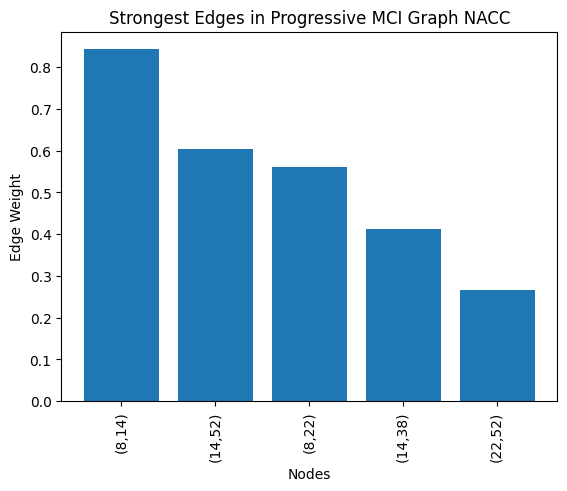

In [68]:
#plot 
top_edges = edges_sorted_shifted[:5]

x_values = [f"({edge[0]},{edge[1]})" for edge in edges_sorted_shifted[:5]]
y_values = [edge[2]['weight'] for edge in edges_sorted_shifted[:5]]

plt.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.xlabel('Nodes')
plt.ylabel('Edge Weight')
plt.title('Strongest Edges in Progressive MCI Graph NACC')
plt.show()

In [70]:
#stable model and graph 
#NEEDS TO BE 378x 132 format for model  (32 brain regions left)
n_stable_norm = n_stable_norm.T
print(n_stable_norm.shape)

(378, 132)


In [71]:
#stable model 
#fit for stable norm df 
#this one did not converge so need to tweak the parameters 
n_stab_model = GraphicalLassoCV(cv=5, max_iter=500)
n_stab_model.fit(n_stable_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 500 iteration: dual gap: -1.794e-04
  warnings.warn(


GraphicalLassoCV(cv=5, max_iter=500)

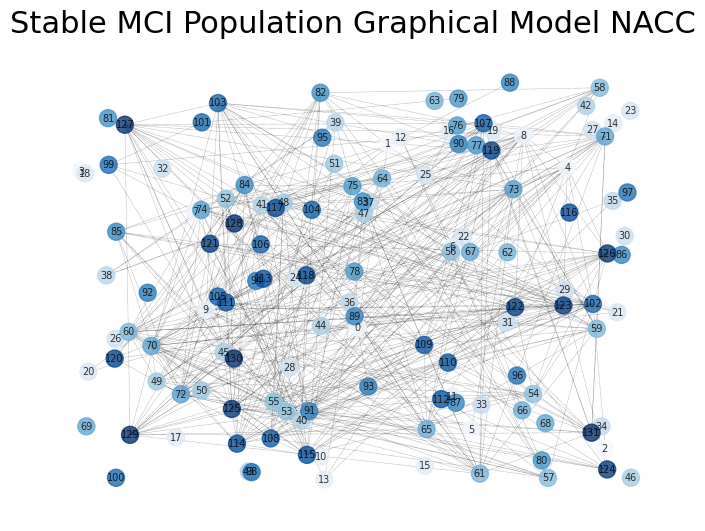

In [74]:
#stable graph 
precision_matrix_ns = n_stab_model.precision_
np.fill_diagonal(precision_matrix_ns, 0)
G_n_stab = nx.Graph(precision_matrix_ns)
pos = nx.random_layout(G_n_stab)
nx.draw(G_n_stab, pos,with_labels=True, font_size=7, style="dotted", node_color=range(len(precision_matrix_ns)),
        cmap=plt.cm.Blues, node_size=150*len(precision_matrix_ns)/132, alpha=.8, width=.3)
plt.title("Stable MCI Population Graphical Model NACC", fontsize=22)
plt.show()

In [75]:
#top 10 strongest edges in stable 
edges_sorted = sorted(G_n_stab.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(edge[0]+1, edge[1]+1, edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(8, 22, {'weight': 0.4766863777198197})
(8, 100, {'weight': 0.4319839363601369})
(13, 21, {'weight': 0.20776500075549015})
(46, 100, {'weight': 0.17101196328349313})
(14, 68, {'weight': 0.14748743034754783})
(8, 14, {'weight': 0.141826598320337})
(13, 67, {'weight': 0.0952060128386469})
(22, 46, {'weight': 0.06696326261016591})
(7, 13, {'weight': 0.03459292023957658})
(14, 38, {'weight': 0.032233059486846356})


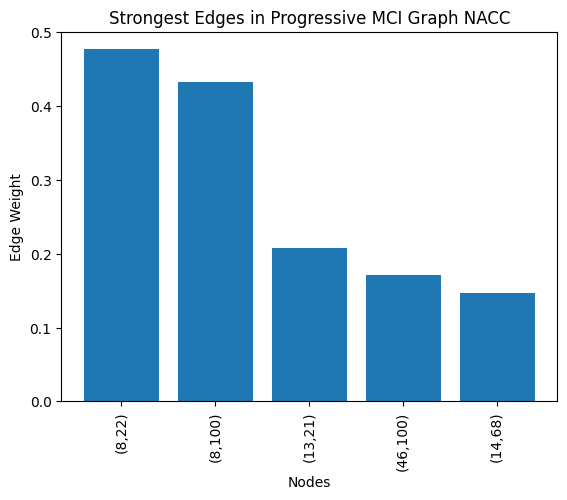

In [76]:
#plot top edges 
#plot 
top_edges = edges_sorted_shifted[:5]

x_values = [f"({edge[0]},{edge[1]})" for edge in edges_sorted_shifted[:5]]
y_values = [edge[2]['weight'] for edge in edges_sorted_shifted[:5]]

plt.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.xlabel('Nodes')
plt.ylabel('Edge Weight')
plt.title('Strongest Edges in Progressive MCI Graph NACC')
plt.show()

In [77]:
#compare graph metrics NACC
#compare graph metrics 

#modularity 
mod_p_n = nx.algorithms.community.modularity(G_n_prog, nx.algorithms.community.greedy_modularity_communities(G_n_prog))
print("Prog Modularity:", mod_p_n)
mod_s_n = nx.algorithms.community.modularity(G_n_stab, nx.algorithms.community.greedy_modularity_communities(G_n_stab))
print("Stable Modularity:", mod_s_n)

#global path effiency 
ge_p_n = nx.global_efficiency(G_n_prog)
print("\nProg Global efficiency:", ge_p_n)
ge_s_n = nx.global_efficiency(G_n_stab)
print("Stable Global efficiency:", ge_s_n)

#clustering coefficient 
cl_p_n = nx.average_clustering(G_n_prog)
print(f"\nProg Clustering Coeff:",cl_p_n)
cl_s_n = nx.average_clustering(G_n_stab)
print(f"Stable Clustering Coeff",cl_s_n)

Prog Modularity: 0.24674217724071967
Stable Modularity: 0.44921233384618686

Prog Global efficiency: 0.44157992135087115
Stable Global efficiency: 0.13351176415020927

Prog Clustering Coeff: 0.26592433529578885
Stable Clustering Coeff 0.3154573928170032


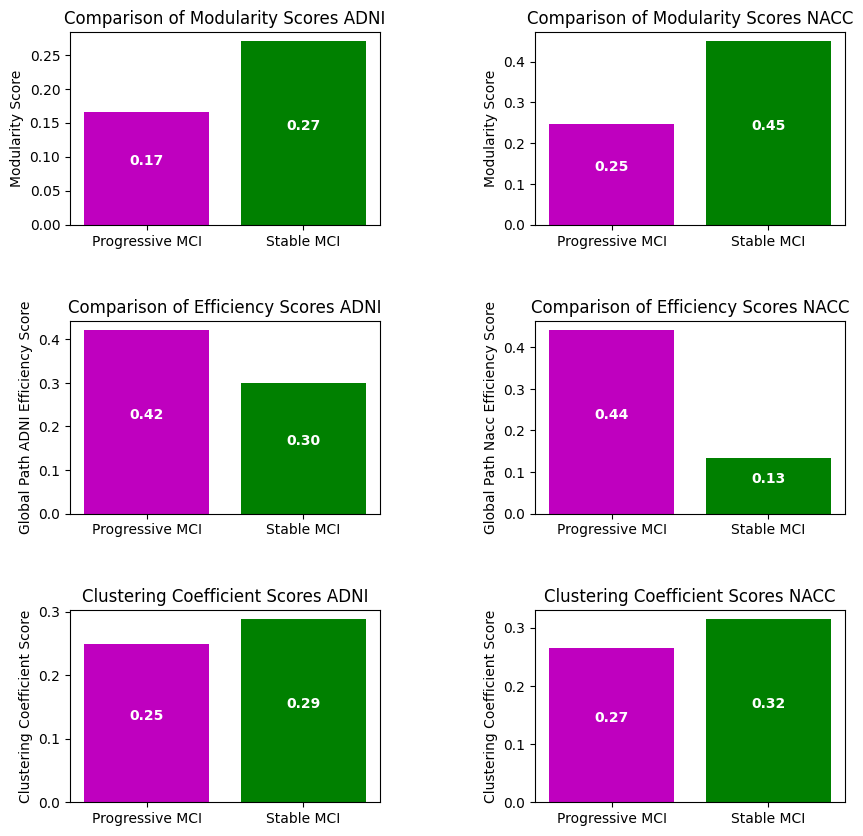

In [78]:
#plot ADNI and NACC together 
colors = ['m','green']
#ADNI 
# Define the data for the three bar plots
m_scores = [mod_p, mod_s]
g_scores = [ge_p, ge_s]
c_scores = [cl_p, cl_s]


#NACC 
# Define the data for the three bar plots
m_scores_n = [mod_p_n, mod_s_n]
g_scores_n = [ge_p_n, ge_s_n]
c_scores_n = [cl_p_n, cl_s_n]

labels = ["Progressive MCI", "Stable MCI"]

# Create a figure with 6 subplots, 2 for each barplot 
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
#add space vetween pots 
plt.subplots_adjust(hspace=.5)

# define function to add text inside bars
def add_text_inside_bar(rects, axs):
    for rect in rects:
        height = rect.get_height()
        axs.text(rect.get_x() + rect.get_width() / 2., height / 2., f"{height:.2f}",
                 ha='center', va='bottom', color='white', fontweight='bold')

# first subplot m score adni 
rects1=axs[0,0].bar(labels,m_scores,color=colors)
axs[0,0].set_ylabel("Modularity Score")
axs[0,0].set_title("Comparison of Modularity Scores ADNI")
add_text_inside_bar(rects1,axs[0,0])


#secon d subplot nacc m 
rects2 = axs[0,1].bar(labels, m_scores_n, color = colors)
axs[0,1].set_ylabel("Modularity Score")
axs[0,1].set_title("Comparison of Modularity Scores NACC")
add_text_inside_bar(rects2,axs[0,1])


# third subplot adni g 
rects3 = axs[1,0].bar(labels, g_scores, color = colors)
axs[1,0].set_ylabel("Global Path ADNI Efficiency Score")
axs[1,0].set_title("Comparison of Efficiency Scores ADNI")
add_text_inside_bar(rects3,axs[1,0])

#fourth subplot nacc g 
rects4 = axs[1,1].bar(labels, g_scores_n, color = colors)
axs[1,1].set_ylabel("Global Path Nacc Efficiency Score")
axs[1,1].set_title("Comparison of Efficiency Scores NACC")
add_text_inside_bar(rects4,axs[1,1])

#fifth subplot adni c 
rects5 = axs[2,0].bar(labels, c_scores, color = colors)
axs[2,0].set_ylabel("Clustering Coefficient Score")
axs[2,0].set_title("Clustering Coefficient Scores ADNI")
add_text_inside_bar(rects5,axs[2,0])

#sixth subplot nacc c 
rects6 = axs[2,1].bar(labels, c_scores_n, color = colors)
axs[2,1].set_ylabel("Clustering Coefficient Score")
axs[2,1].set_title("Clustering Coefficient Scores NACC")
add_text_inside_bar(rects6,axs[2,1])

# Adjust the spacing between subplots and display the figure
plt.subplots_adjust(wspace=0.5)
plt.show()

In [86]:
#significance tests 
all_mod_p = [mod_p,mod_p_n]
all_mod_s = [mod_s, mod_s_n]

all_c_p = [cl_p,cl_p_n]
all_c_s = [cl_s,cl_s_n]

all_g_p = [ge_p,ge_p_n]
all_g_s = [ge_s,ge_s_n]

#modularity
t_stat,p_val = stats.ttest_ind(all_mod_p,all_mod_s)
print('Modularity t-stat: {:.3f}'.format(t_stat))
print("Modularity pval: {:.3f}".format(p_val))

#clustering
t_stat,p_val = stats.ttest_ind(all_c_p,all_c_s)
print('Clustering t-stat: {:.3f}'.format(t_stat))
print("Clustering pval: {:.3f}".format(p_val))


#clustering coeff
t_stat,p_val = stats.ttest_ind(all_g_p,all_g_s)
print('Global path effiency t-stat: {:.3f}'.format(t_stat))
print("Global path effiency pval: {:.3f}".format(p_val))

Modularity t-stat: -1.558
Modularity pval: 0.260
Clustering t-stat: -2.815
Clustering pval: 0.106
Global path effiency t-stat: 2.566
Global path effiency pval: 0.124


In [87]:
#try wilcoxon rank sum test 
#modularity 
U_stat, p_value = stats.ranksums(all_mod_p,all_mod_s)
print('Modularity U-stat: {:.3f}'.format(U_stat))
print('Modularity p value: {:.3f}'.format(p_val))

Modularity U-stat: -1.549
Modularity p value: 0.124


In [ ]:
#man whitney test 
U_stat, p_value = stats.mannwhitneyu(all_mod_p,all_mod_s)


In [ ]:
#bootstrap 
#before build the graph, randomly sampole weight replacement of whole dataset 
#500 patients, sample 500 times with replacement
#then any quanity you are esitmating, will be different, then ypu use these as samples of your quanity and estimate the variance at the end
#unbiased estimate of the variance 
#if I want different type of test 
#computing var, to see if the error bars overlap (whicvch gives you a p value)


#get estimate of the vairnace from bootstrapping 
#t test the variance of the 2 groups 
#for each one of these vars end up with a boot strap and then a boot strapped 


#should read exactly on how bootstrap works, see what is the estimator 
# in sklearn resample 
#run this on the whole dataset (resample from very beginning)

#whole bootstrapping pipeline 

In [26]:
#compare the degree centralities of each node between prog and stable 
import networkx as nx
import numpy as np

# Calculate degree centrality for G_prog
deg_centrality_prog = nx.degree_centrality(G_prog)

# Calculate degree centrality for G_stab
deg_centrality_stab = nx.degree_centrality(G_stab)

# Create a list to store permuted test statistics
permuted_test_stats = []

# Define the number of permutations
num_permutations = 1000

# Perform the permutation test
for _ in range(num_permutations):
    # Randomly shuffle node labels within G_prog and G_stab
    nodes_prog = list(G_prog.nodes())
    np.random.shuffle(nodes_prog)
    shuffled_G_prog = G_prog.subgraph(nodes_prog)

    nodes_stab = list(G_stab.nodes())
    np.random.shuffle(nodes_stab)
    shuffled_G_stab = G_stab.subgraph(nodes_stab)

    # Calculate degree centrality for the shuffled graphs
    deg_centrality_shuffled_prog = nx.degree_centrality(shuffled_G_prog)
    deg_centrality_shuffled_stab = nx.degree_centrality(shuffled_G_stab)

    # Calculate the test statistic (e.g., absolute difference in means)
    observed_diff = np.abs(np.mean(list(deg_centrality_prog.values())) - np.mean(list(deg_centrality_stab.values())))

    # Append the test statistic to the list
    permuted_test_stats.append(observed_diff)

# Calculate the observed test statistic
observed_test_statistic = np.abs(np.mean(list(deg_centrality_prog.values())) - np.mean(list(deg_centrality_stab.values())))

# Calculate the p-value
p_value = (np.sum(np.array(permuted_test_stats) >= observed_test_statistic) + 1) / (num_permutations + 1)

# Print the p-value
print(f"P-value: {p_value:.4f}")

# Interpret the results based on the p-value
if p_value < 0.05:
    print("There is a statistically significant difference in degree centrality between the two groups.")
else:
    print("There is no statistically significant difference in degree centrality between the two groups.")


P-value: 1.0000
There is no statistically significant difference in degree centrality between the two groups.


In [27]:
#tells you which nodes are statistically different between groups 
import networkx as nx
import numpy as np

# Calculate degree centrality for G_prog
deg_centrality_prog = nx.degree_centrality(G_prog)

# Calculate degree centrality for G_stab
deg_centrality_stab = nx.degree_centrality(G_stab)

# Set the significance level (alpha)
alpha = 0.05

# Create lists to store significant nodes
significant_nodes = []

# Iterate through nodes and test for significance
for node in G_prog.nodes():
    # Calculate the observed degree centrality difference
    observed_diff = deg_centrality_prog[node] - deg_centrality_stab[node]

    # Create a list to store permuted differences
    permuted_diffs = []

    # Perform a permutation test
    for _ in range(num_permutations):
        np.random.shuffle(nodes_prog)
        np.random.shuffle(nodes_stab)
        permuted_diff = deg_centrality_prog[node] - deg_centrality_stab[node]
        permuted_diffs.append(permuted_diff)

    # Calculate the p-value for the node
    p_value = (np.sum(np.array(permuted_diffs) >= observed_diff) + 1) / (num_permutations + 1)

    # Apply Bonferroni correction
    adjusted_alpha = alpha / len(G_prog.nodes())

    # Check if the node is significant
    if p_value < adjusted_alpha:
        significant_nodes.append(node)

# Print the significant nodes
print("Significant Nodes:")
for node in significant_nodes:
    print(f"Node {node} is significant.")


Significant Nodes:


In [29]:
#for ADNI 


#compare degree centrality of each node between 2 graphs 
import networkx as nx

# Assuming you have already created G_prog and G_stab

# Calculate degree centrality for G_prog and G_stab
deg_centrality_prog = nx.degree_centrality(G_prog)
deg_centrality_stab = nx.degree_centrality(G_stab)

# Define a threshold for considering differences
threshold = 0.05  # You can adjust this threshold as needed

# Create a dictionary to store nodes with significantly different degree centrality
different_degree_nodes = {}

# Compare degree centrality values for each node
for node in G_prog.nodes():
    deg_prog = deg_centrality_prog.get(node, 0)  # Get degree centrality for node in G_prog
    deg_stab = deg_centrality_stab.get(node, 0)  # Get degree centrality for node in G_stab
    
    # Check if the absolute difference is greater than the threshold
    if abs(deg_prog - deg_stab) > threshold:
        different_degree_nodes[node] = (deg_prog, deg_stab)

# Print nodes with significantly different degree centrality
for node, (deg_prog, deg_stab) in different_degree_nodes.items():
    print(f"Node {node}: Degree Centrality in G_prog = {deg_prog}, Degree Centrality in G_stab = {deg_stab}")



#correspond these to brain regions 
#Node 7: Degree Centrality in G_prog = 0.05426356589147287, Degree Centrality in G_stab = 0.0 left amygdala 
#Node 11: Degree Centrality in G_prog = 0.06201550387596899, Degree Centrality in G_stab = 0.007751937984496124 right brainstem 
# Node 14: Degree Centrality in G_prog = 0.14728682170542634, Degree Centrality in G_stab = 0.23255813953488372 right cerebellum 
# Node 28: Degree Centrality in G_prog = 0.05426356589147287, Degree Centrality in G_stab = 0.13953488372093023 right pallidum 
# Node 39: Degree Centrality in G_prog = 0.07751937984496124, Degree Centrality in G_stab = 0.0 left cerebellar vermal lobules I-V
# Node 51: Degree Centrality in G_prog = 0.12403100775193798, Degree Centrality in G_stab = 0.18604651162790697   left angular gyrus 
# Node 72: Degree Centrality in G_prog = 0.12403100775193798, Degree Centrality in G_stab = 0.1937984496124031  right inf temporal gyrus 
# Node 76: Degree Centrality in G_prog = 0.11627906976744186, Degree Centrality in G_stab = 0.17054263565891473  right lateral oribtal gyrus 
# Node 113: Degree Centrality in G_prog = 0.2558139534883721, Degree Centrality in G_stab = 0.18604651162790697  left post central gyrus 
# Node 120: Degree Centrality in G_prog = 0.17829457364341084, Degree Centrality in G_stab = 0.12403100775193798  right precentral gyrus 
# Node 121: Degree Centrality in G_prog = 0.10077519379844961, Degree Centrality in G_stab = 0.015503875968992248 left planum temporale 
# Node 140: Degree Centrality in G_prog = 0.05426356589147287, Degree Centrality in G_stab = 0.10852713178294573 right triangular part of the inf frontal gyrus 



Node 7: Degree Centrality in G_prog = 0.05426356589147287, Degree Centrality in G_stab = 0.0
Node 11: Degree Centrality in G_prog = 0.06201550387596899, Degree Centrality in G_stab = 0.007751937984496124
Node 14: Degree Centrality in G_prog = 0.14728682170542634, Degree Centrality in G_stab = 0.23255813953488372
Node 28: Degree Centrality in G_prog = 0.05426356589147287, Degree Centrality in G_stab = 0.13953488372093023
Node 39: Degree Centrality in G_prog = 0.07751937984496124, Degree Centrality in G_stab = 0.0
Node 51: Degree Centrality in G_prog = 0.12403100775193798, Degree Centrality in G_stab = 0.18604651162790697
Node 72: Degree Centrality in G_prog = 0.12403100775193798, Degree Centrality in G_stab = 0.1937984496124031
Node 76: Degree Centrality in G_prog = 0.11627906976744186, Degree Centrality in G_stab = 0.17054263565891473
Node 113: Degree Centrality in G_prog = 0.2558139534883721, Degree Centrality in G_stab = 0.18604651162790697
Node 120: Degree Centrality in G_prog = 0.1

In [ ]:
import networkx as nx
import numpy as np
from scipy import stats

# Assuming you have already created G_prog and G_stab

# Calculate degree centrality for G_prog and G_stab
deg_centrality_prog = nx.degree_centrality(G_prog)
deg_centrality_stab = nx.degree_centrality(G_stab)

# Define a significance level (alpha)
alpha = 0.05  # You can adjust this based on your desired significance level

# Initialize a dictionary to store results for each node
node_results = {}

# Perform t-test for each node
for node in G_prog.nodes():
    deg_prog = deg_centrality_prog.get(node, 0)
    deg_stab = deg_centrality_stab.get(node, 0)
    
    t_statistic, p_value = stats.ttest_ind([deg_prog], [deg_stab])
    
    if p_value < alpha:
        node_results[node] = "Significant"
    else:
        node_results[node] = "Not Significant"

# Print the results
for node, result in node_results.items():
    print(f"Node {node}: {result}")


In [ ]:
#repeat the comparisons of progs norm for adni 
#compare degree centrality of each node between 2 graphs 

# Calculate degree centrality for G_prog and G_stab
deg_centrality_prog_n = nx.degree_centrality(G_n_prog)
deg_centrality_stab_n = nx.degree_centrality(G_n_stab)

# Define a threshold for considering differences
threshold = 0.05  # You can adjust this threshold as needed

# Create a dictionary to store nodes with significantly different degree centrality
different_degree_nodes = {}

# Compare degree centrality values for each node
for node in G_prog.nodes():
    deg_prog = deg_centrality_prog_n.get(node, 0)  # Get degree centrality for node in G_prog
    deg_stab = deg_centrality_stab_n.get(node, 0)  # Get degree centrality for node in G_stab
    
    # Check if the absolute difference is greater than the threshold
    if abs(deg_prog - deg_stab) > threshold:
        different_degree_nodes[node] = (deg_n_prog, deg_n_stab)

# Print nodes with significantly different degree centrality
for node, (deg_n_prog, deg_n_stab) in different_degree_nodes.items():
    print(f"Node {node}: Degree Centrality in G_prog = {deg_n_prog}, Degree Centrality in G_stab = {deg_n_stab}")